In [0]:
!pip install sklearn_crfsuite
!pip install eli5

     |████████████████████████████████| 757kB 21.8MB/s 
     |████████████████████████████████| 112kB 56.1MB/s 


In [0]:
import nltk
import sklearn_crfsuite
import eli5
import pprint
import ast
import scipy
from joblib import load, dump
from nltk.tag import pos_tag
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn_crfsuite import metrics, scorers
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [0]:
# loading datasets
f = open("train_with_pos_conll.txt")
train_sets = ast.literal_eval(f.read())
f = open("test_with_pos_conll.txt")
test_sets = ast.literal_eval(f.read())

In [0]:
# defining features
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

In [0]:
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [0]:
X_train = [sent2features(s) for s in train_sets]
y_train = [sent2labels(s) for s in train_sets]

X_test = [sent2features(s) for s in test_sets]
y_test = [sent2labels(s) for s in test_sets]

pprint.pprint(X_train[0][1])

{'+1:postag': 'JJ',
 '+1:postag[:2]': 'JJ',
 '+1:word.istitle()': True,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'german',
 '-1:postag': 'NNP',
 '-1:postag[:2]': 'NN',
 '-1:word.istitle()': False,
 '-1:word.isupper()': True,
 '-1:word.lower()': 'eu',
 'bias': 1.0,
 'postag': 'VBZ',
 'postag[:2]': 'VB',
 'word.isdigit()': False,
 'word.istitle()': False,
 'word.isupper()': False,
 'word.lower()': 'rejects',
 'word[-3:]': 'cts'}


## Training CRF model with hand-picked parameters

In [0]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=20,
    all_possible_transitions=False,
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=20,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [0]:
eli5.show_weights(crf)

In [0]:
labels = list(crf.classes_)

y_pred = crf.predict(X_test)
precision = metrics.flat_precision_score(y_test, y_pred, 
                      average='micro', labels=labels)
print(f'Best precision score: {precision}')

Best precision score: 0.9419702580607635


In [0]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           O      0.976     0.989     0.983     42974
       B-LOC      0.000     0.000     0.000         0
       I-LOC      0.759     0.688     0.722      2094
      B-MISC      0.000     0.000     0.000         4
      I-MISC      0.850     0.555     0.672      1264
       B-ORG      0.000     0.000     0.000         0
       I-ORG      0.651     0.568     0.607      2092
       I-PER      0.785     0.869     0.825      3149

   micro avg      0.942     0.942     0.942     51577
   macro avg      0.503     0.459     0.476     51577
weighted avg      0.940     0.942     0.940     51577



## Searching for the best parameters

In [0]:
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 59.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f16efe5c6a0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f174fe81be0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_sco

In [0]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.007402078119609373, 'c2': 0.03677437513909534}
best CV score: 0.9695241911799248
model size: 2.27M


Dark blue => 0.9589, dark red => 0.9695


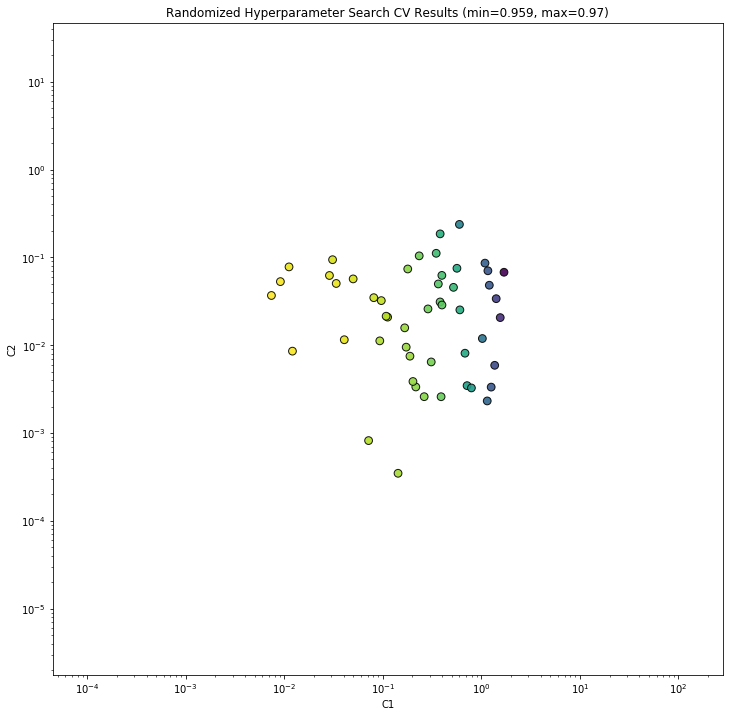

In [0]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Results of the best CRF model

In [0]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           O      0.989     0.997     0.993     42974
       B-LOC      0.000     0.000     0.000         0
       I-LOC      0.918     0.866     0.892      2094
      B-MISC      0.500     0.500     0.500         4
      I-MISC      0.898     0.816     0.855      1264
       B-ORG      0.000     0.000     0.000         0
       I-ORG      0.872     0.825     0.848      2092
       I-PER      0.931     0.930     0.930      3149

   micro avg      0.976     0.976     0.976     51577
   macro avg      0.639     0.617     0.627     51577
weighted avg      0.976     0.976     0.976     51577



In [0]:
eli5.show_weights(crf)

## Saving the best model

In [0]:
dump(crf, 'best_crf_conll.joblib') 

['best_crf_conll.joblib']

In [0]:
new_crf = load('best_crf_conll.joblib')

In [0]:
y_pred = new_crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           O      0.989     0.997     0.993     42974
       B-LOC      0.000     0.000     0.000         0
       I-LOC      0.918     0.866     0.892      2094
      B-MISC      0.500     0.500     0.500         4
      I-MISC      0.898     0.816     0.855      1264
       B-ORG      0.000     0.000     0.000         0
       I-ORG      0.872     0.825     0.848      2092
       I-PER      0.931     0.930     0.930      3149

   micro avg      0.976     0.976     0.976     51577
   macro avg      0.639     0.617     0.627     51577
weighted avg      0.976     0.976     0.976     51577



In [0]:
def predict_text(text):
    sentences = nltk.sent_tokenize(text)
    result = []
    for sentence in sentences:
        splitted = nltk.word_tokenize(sentence)
        for word in splitted:
            pos = pos_tag([word])[0][1]
            result.append((word, pos))
    return sent2features(result)

In [0]:
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

with open("input.txt") as file:
    text = file.read()
answer = new_crf.predict_single(predict_text(text))
sentences = nltk.sent_tokenize(text)
words = []
for sentence in sentences:
    splitted = nltk.word_tokenize(sentence)
    for word in splitted:
        words.append(word)
entity_text = ''
for i, entity in enumerate(answer):
    if entity != 'O':
        entity_text += f'{color.BOLD}{words[i]} ({entity}{color.END}) '
    else:
        entity_text += f'{words[i]} '
print(entity_text)

TensorFlow is an end-to-end open source platform for machine learning . It has a comprehensive , flexible ecosystem of tools , libraries , and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications . TensorFlow was originally developed by researchers and engineers working on the Google (B-Fram) Brain (I-Fram) team within Google (B-Fram) 's (I-Fram) Machine Intelligence Research organization for the purposes of conducting machine learning and deep neural networks research . The system is general enough to be applicable in a wide variety of other domains , as well . TensorFlow provides stable Python (B-PL) and C++ (B-PL) APIs , as well as non-guaranteed backwards compatible API for other languages . Keep up-to-date with release announcements and security updates by subscribing to announce @ tensorflow.org . See all the mailing lists . See the TensorFlow install guide for the pip package , to enable GPU supp

### Results of DeepPavlov model

![title](nn_results.png)